In [ ]:
!python3.10 -m pip install ./sage

In [2]:
from sage.spelling_corruption import CharAugConfig, CharAugCorruptor, WordAugConfig, WordAugCorruptor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from string import punctuation
# from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
# from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from wordcloud import WordCloud

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup

from torch.utils.data import Dataset

In [3]:
SEED=2024
nltk.download('stopwords')
nltk.download('punkt')

russian_stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
PATH = "./train_SecondPilot/"
train_data = pd.read_csv(PATH + "train_data.csv")
# train_data = pd.read_csv(PATH + "train_aug.txt")
answer_class = pd.read_csv(PATH + "answer_class.csv")
sample = pd.read_csv(PATH + "sample_submission.csv")

<AxesSubplot: >

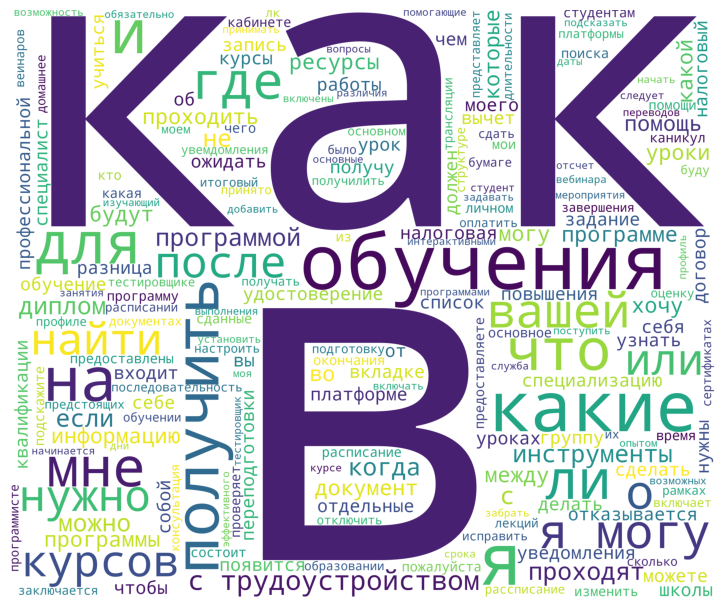

In [5]:
# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus
# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word.lower())
    return corpus
# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                            #   stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

corpus = get_corpus(train_data['Question'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

In [6]:
# Удаление знаков пунктуации из текста
def remove_punct(text):
    table = {33: ' ', 34: ' ', 35: ' ', 36: ' ', 37: ' ', 38: ' ', 39: ' ', 40: ' ', 41: ' ', 42: ' ', 43: ' ', 44: ' ', 45: ' ', 46: ' ', 47: ' ', 58: ' ', 59: ' ', 60: ' ', 61: ' ', 62: ' ', 63: ' ', 64: ' ', 91: ' ', 92: ' ', 93: ' ', 94: ' ', 95: ' ', 96: ' ', 123: ' ', 124: ' ', 125: ' ', 126: ' '}
    return text.translate(table)

train_data['Question_clean'] = train_data['Question'].map(lambda x: x.lower())
train_data['Question_clean'] = train_data['Question_clean'].map(lambda x: remove_punct(x))
train_data['Question_clean'] = train_data['Question_clean'].map(lambda x: x.split(' '))
train_data['Question_clean'] = train_data['Question_clean'].map(lambda x: [token for token in x if token not in russian_stopwords\
                                                                  and token != " " \
                                                                  and token.strip() not in punctuation])
train_data['Question_clean'] = train_data['Question_clean'].map(lambda x: ' '.join(x))

<AxesSubplot: >

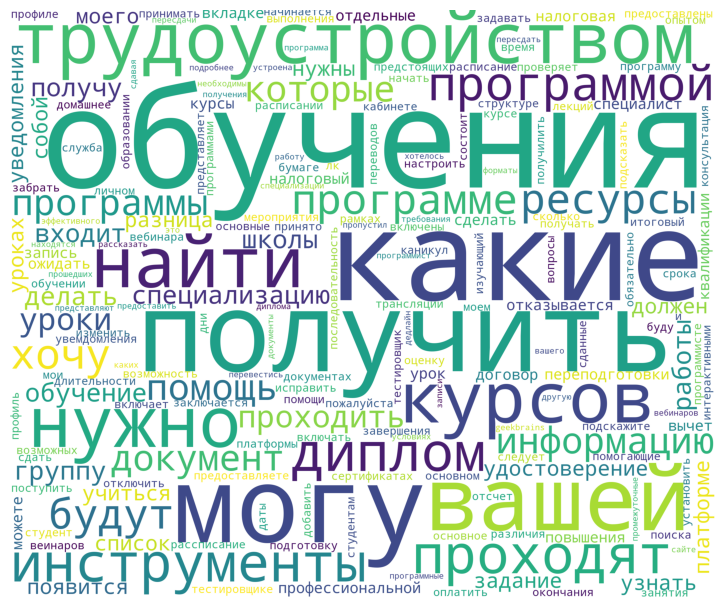

In [7]:
corpus = get_corpus(train_data['Question_clean'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

In [8]:
X = train_data.Question_clean
y = train_data['answer_class']

In [9]:
import torch
torch.cuda.is_available()

True

In [10]:
class CustomDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=2048):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

class BertClassifier:

    def __init__(self, model_path, tokenizer_path, n_classes=2, epochs=1, model_save_path='./bert.pt'):
        self.model = BertForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model_save_path=model_save_path        
        self.max_len = 2048
        self.epochs = epochs
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        self.model.to(self.device)
    
    def preparation(self, X_train, y_train, X_valid, y_valid):
        # create datasets
        self.train_set = CustomDataset(X_train, y_train, self.tokenizer)
        self.valid_set = CustomDataset(X_valid, y_valid, self.tokenizer)

        # create data loaders
        self.train_loader = DataLoader(self.train_set, batch_size=2, shuffle=True)
        self.valid_loader = DataLoader(self.valid_set, batch_size=2, shuffle=True)

        # helpers initialization
        self.optimizer = AdamW(self.model.parameters(), lr=2e-5, correct_bias=False)
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=0,
                num_training_steps=len(self.train_loader) * self.epochs
            )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)
            
    def fit(self):
        self.model = self.model.train()
        losses = []
        correct_predictions = 0

        for data in self.train_loader:
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)
        return train_acc, train_loss
    
    def eval(self):
        self.model = self.model.eval()
        losses = []
        correct_predictions = 0

        with torch.no_grad():
            for data in self.valid_loader:
                input_ids = data["input_ids"].to(self.device)
                attention_mask = data["attention_mask"].to(self.device)
                targets = data["targets"].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                    )

                preds = torch.argmax(outputs.logits, dim=1)
                loss = self.loss_fn(outputs.logits, targets)
                correct_predictions += torch.sum(preds == targets)
                losses.append(loss.item())
        
        val_acc = correct_predictions.double() / len(self.valid_set)
        val_loss = np.mean(losses)
        return val_acc, val_loss
    
    def train(self):
        best_accuracy = 0
        for epoch in range(self.epochs):
            print(f'Epoch {epoch + 1}/{self.epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')

            val_acc, val_loss = self.eval()
            print(f'Val loss {val_loss} accuracy {val_acc}')
            print('-' * 10)

            if val_acc > best_accuracy:
                torch.save(self.model, self.model_save_path)
                best_accuracy = val_acc

        self.model = torch.load(self.model_save_path)
    
    def predict(self, text):
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }
        
        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)
        
        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction

In [11]:
classifier = BertClassifier(        
        model_path='cointegrated/rubert-tiny2',
        tokenizer_path='cointegrated/rubert-tiny2',
        n_classes=30,
        epochs=3,
        model_save_path='./bert.pt'
)

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2

In [15]:
def augment(text, label):
    NUM_AUGS = 11
    aug_text = []
    aug_label = []
    
    for t, l in zip(text, label):
    
        aug_text.append(t)    
        aug_label.append(l)

        configChar = CharAugConfig(
            unit_prob=0.3, # proportion of characters that is going to undergo edits
            min_aug=1, # minimum number of edits
            max_aug=5, # maximum number of edits 
            mult_num=3 # `multiply` edit
        )
        corruptorChar = CharAugCorruptor.from_config(configChar)

        aug_text.append(corruptorChar.corrupt(t, action="shift"))
        aug_text.append(corruptorChar.corrupt(t, action="orfo"))
        aug_text.append(corruptorChar.corrupt(t, action="delete"))
        aug_text.append(corruptorChar.corrupt(t, action="multiply"))
        aug_text.append(corruptorChar.corrupt(t, action="swap"))
        aug_text.append(corruptorChar.corrupt(t, action="insert"))

        configWord = WordAugConfig(
            unit_prob=0.4, # proportion of characters that is going to undergo edits
            min_aug=1, # minimum number of edits
            max_aug=5, # maximum number of edits 
        )
        corruptorWord = WordAugCorruptor.from_config(configWord)
        aug_text.append(corruptorWord.corrupt(t, action="delete"))
        aug_text.append(corruptorWord.corrupt(t, action="swap"))
        aug_text.append(corruptorWord.corrupt(t, action="stopword"))
        aug_text.append(corruptorWord.corrupt(t, action="reverse"))
        aug_text.append(corruptorWord.corrupt(t, action="replace"))

        for i in range(NUM_AUGS): 
            aug_label.append(l)

    return aug_text, aug_label

In [16]:
print(augment(text=['Когда я получу диплом?', 'Какая последовательность курсов в программе?'], label=[2,6]))

(['Когда я получу диплом?', 'КОгда я получу диПлом?', 'Кёгда я пцлучуядиблом?', 'Кгда я плучудилом?', 'Коогда я поолучу диплом?', 'оКгда я получ удпилом?', 'Коыгда я поёглучу цдипвлом?', 'я получу диплом?', 'диплом? я получу Когда', 'же Когда я получу диплом?', 'когда я получу диплом?', 'Когда я получу диплом?', 'Какая последовательность курсов в программе?', 'КакАя последовательность курСов в Программе?', 'Какоя последовательсость курщов в брограмме?', 'Какя последовательость куров в рограмме?', 'Какаая последовательность курссов в программе?', 'Каакя последовательность кусров вп рограмме?', 'Какаыя последовательнёгость курсцов в пврограмме?', 'последовательность курсов программе?', 'в Какая курсов последовательность программе?', 'нуу Какая последовательность курсов эти в программе?', 'какая последовательность курсов В программе?', 'Какая последовательность курсов йф программе?'], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])


In [17]:
skf = StratifiedKFold(n_splits=3)
for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i}:")

    X_train, y_train = augment(list(X.loc[train_index]), list(y.loc[train_index]) )
    X_valid = list(X.loc[valid_index])
    y_valid=list(y.loc[valid_index])
    classifier.preparation(
            X_train,
            y_train,
            X_valid,
            y_valid,
        )
    
    classifier.train()

    predictions = [classifier.predict(t) for t in list(X.loc[valid_index])]
    print(metrics.f1_score(list(y.loc[valid_index]), predictions, average='micro'))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Fold 0:


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
Train loss 1.9407975740622783 accuracy 0.7898550724637681
Val loss 1.636685570081075 accuracy 0.9130434782608695
----------
Epoch 2/3
Train loss 1.156756800909837 accuracy 0.9510869565217391
Val loss 1.472091719508171 accuracy 0.8260869565217391
----------
Epoch 3/3
Train loss 0.9309512741755748 accuracy 0.9782608695652174
Val loss 1.3392851998408635 accuracy 0.8260869565217391
----------
0.9130434782608695
Fold 1:


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
Train loss 1.0744873743126357 accuracy 0.907608695652174
Val loss 0.8058026308814684 accuracy 0.8695652173913043
----------
Epoch 2/3
Train loss 0.5303258131379667 accuracy 0.9692028985507246
Val loss 0.6244887945552667 accuracy 0.8695652173913043
----------
Epoch 3/3
Train loss 0.4014477803223375 accuracy 0.9782608695652174
Val loss 0.6020292639732361 accuracy 0.8695652173913043
----------
0.8695652173913043
Fold 2:


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
Train loss 0.5203153227010499 accuracy 0.9601449275362319
Val loss 0.30300690047442913 accuracy 0.9565217391304348
----------
Epoch 2/3
Train loss 0.20172178932884033 accuracy 0.9963768115942029
Val loss 0.2392549505457282 accuracy 0.9565217391304348
----------
Epoch 3/3
Train loss 0.1445810654187116 accuracy 0.9981884057971014
Val loss 0.23030991355578104 accuracy 0.9565217391304348
----------
0.9565217391304348
